In [108]:
import requests
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import LineString
import matplotlib.pyplot as plt

In [109]:
import contextily as ctx
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))


In [110]:
# authentication
payload = {"client_id": '98914944-a2e6-483f-833b-c9d5e95730a9' ,
           "client_secret": "WrFtiNXG1wWHZCzivEySFcOihwjNAs2huNncHTwdvFQ=",
           "grant_type": "client_credentials",
           "scope": "transportapi:all"
          }

r = requests.post('https://identity.whereismytransport.com/connect/token', 
                  data=payload)
print(r)
if 'access_token' in r.json():
    access_token = r.json()['access_token']

<Response [200]>


In [142]:
# get a journey
start_lon = 28.226581
start_lat = -26.051401
end_lon = 28.056754 
end_lat = -26.111866

payload = {
    "geometry":{
        "type": "MultiPoint",
        "coordinates":[
            [
                start_lon, start_lat
            ],
            [
                end_lon, end_lat
            ]
        ]
    },
    "maxIteneraries": 5,
    "time": "2018-10-29T08:00:00Z",
    "timeType": "ArriveBefore"
}


headers = {
    "Authorization": "Bearer "+ access_token,
    "Content-Type": "application/json",
    "Accept": "application/json"
}

journey = requests.post(
    'https://platform.whereismytransport.com/api/journeys', 
    json=payload,
    headers=headers
)
print(journey)

<Response [201]>


In [144]:
options = {}
for i, itinerary in enumerate(journey.json()["itineraries"]):
    duration = itinerary['duration']
    distance = itinerary['distance']['value']
    fare = 0
    mode = []
    points = []
    for leg in itinerary['legs']:
        if "fare" in leg:
            fare += leg['fare']['cost']['amount']
        if leg['type'] != 'Walking':
            mode.append(leg['line']['agency']['name'])
        else:
            mode.append(leg['type'])
        points += leg["geometry"]["coordinates"]    
    print(duration, fare, distance, mode)
    options[i] = {"duration": duration,
                 "fare": fare,
                 "distance": distance,
                 "mode": mode,
                 "points": points}

4599 40.0 30329 ['Walking', 'Metrorail Gauteng', 'Walking', 'Gautrain', 'Walking']
5019 40.0 30329 ['Walking', 'Metrorail Gauteng', 'Walking', 'Gautrain', 'Walking']
7373 53.0 30448 ['Walking', 'Gauteng Taxis', 'Walking', 'Metrorail Gauteng', 'Walking', 'Gautrain', 'Walking']


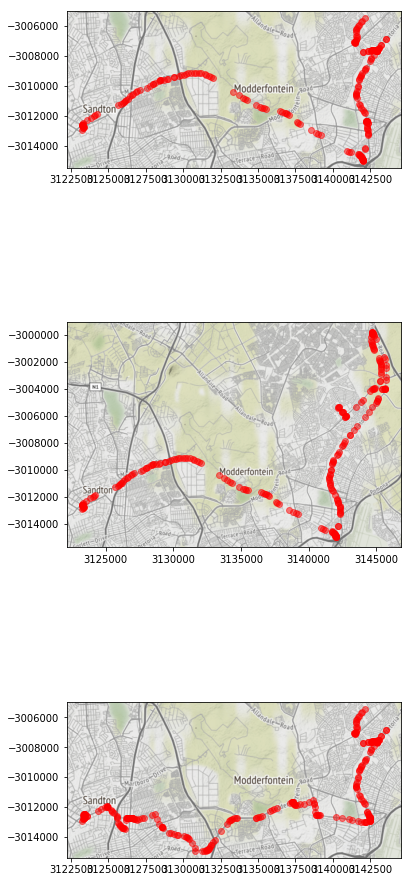

In [113]:
fig, ax = plt.subplots(len(options.keys()), figsize=(6,18))
for key in list(options.keys()):
    option = options[key]
    df = pd.DataFrame(data=option['points'],columns=['lon', 'lat'])
    df['coordinates'] = list(zip(df.lon, df.lat))
    df['coordinates'] = df['coordinates'].apply(Point)
    gdf = gpd.GeoDataFrame(df, geometry="coordinates")
    gdf.crs = {'init': 'epsg:4326'}
    gdf.to_crs(epsg=3857, inplace=True)
    gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='red', color='red', ax=ax[key])
    add_basemap(ax[key], zoom=12)

In [163]:
petrol_usage_idling = 4 # L/h
petrol_usage_driving = 0.06# L/km
travel_time = (90+45)/2/60 # hours
travel_distance = 28.6 #km
petrol_cost = 16.85 #R
car_maintenance = 0.27 # R/km
tolls = 3.98# R
car_usage_cost = petrol_usage_idling * travel_time * petrol_cost + petrol_usage_driving * travel_distance * petrol_cost + car_maintenance * travel_distance * petrol_cost + tolls

In [164]:
car_usage_cost

238.83530000000005

In [165]:
travel_time

1.125

In [166]:
table = pd.DataFrame(columns = ['Route', 'Duration (minutes)', 'Price (R)', 'Traffix Points'])

In [167]:
table.

,Route,Duration (minutes),Price (R),Traffix Points
